In [1]:
from notepad import WaterStorage, Heatpump
from pyrecoy.forecasts import Mipf
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import cufflinks
cufflinks.go_offline()
from numpy.polynomial import Polynomial
import numpy as np

In [3]:
import plotly.express as px
from pyrecoy.colors import *

### Setup & Load data

In [36]:
start = '2018-11-01'
end = '2018-11-03'

mipf = Mipf(
    start = start,
    end = end, 
    tidy=True, 
    include_nextQ=False,
    folder_path=r"C:\Users\Shahla Huseynova\Recoy\Recoy - Documents\03 - Libraries\12 - Data Management\Forecast Data"
).data
# mipf.columns
price_data = mipf[['DAM', 'POS', 'NEG', 'ForeNeg', 'ForePos']]
# price_data.index = price_data.index.tz_convert('Europe/Amsterdam')
price_data = price_data.resample('15T').mean()

df = pd.read_excel('Demand_Data_Smurfit_Preprocessed.xlsx', sheet_name='nov2018', index_col=0)
df = df[start:end]
df.index = df.index.tz_localize('Europe/Amsterdam')
df = df.resample('15T').mean()
df=df.drop(['Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'], axis=1)

for col in price_data.columns:
    df[col] = price_data[col]

df.head()

Tsource (VDG)  Tsink (VDG)  MW (VDG)  \
2018-11-01 00:00:00+01:00      64.964783   142.003109       0.0   
2018-11-01 00:15:00+01:00      54.578777   138.960493       0.0   
2018-11-01 00:30:00+01:00      65.166672   139.885329       0.0   
2018-11-01 00:45:00+01:00      65.358078   139.731901       0.0   
2018-11-01 01:00:00+01:00      64.947536   139.577871       0.0   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)    DAM    POS  \
2018-11-01 00:00:00+01:00      19.897433   147.731814       0.0  44.90  46.39   
2018-11-01 00:15:00+01:00      17.950905   148.138964       0.0  44.90  43.08   
2018-11-01 00:30:00+01:00      33.500757   147.585426       0.0  44.90  43.13   
2018-11-01 00:45:00+01:00      42.203876   147.547612       0.0  44.90  46.29   
2018-11-01 01:00:00+01:00      18.702675   148.260335       0.0  42.46  32.03   

                             NEG    ForeNeg    ForePos  
2018-11-01 00:00:00+01:00  46.39  53.603333  44.623333  
2018-11-01 00:15:00+01:00  43.08  68.962000  63.177333  
2018-11-01 00:30:00+01:00  43.13  55.415333  57.922667  
2018-11-01 00:45:00+01:00  46.29  57.633333  54.712667  
2018-11-01 01:00:00+01:00  32.03  37.354000  35.400000

### Create asset

In [17]:
waterstorage = WaterStorage(
    name='MyStorage',
    max_power=10,
    min_power=-10,
    roundtrip_eff=0.90,
    capacity_per_volume = 50 * 1e-3,
    volume = 1000,
    lifetime = 25,
    temperature = 368, #K
    min_storagelevel = 5,
)
waterstorage.set_freq('15T')
waterstorage.storagelevel

5

In [42]:
def cop_curve(Tsink, Tsource):
    c0 = Tsink / (Tsink - Tsource)  
    return Polynomial([c0])

heatpump = Heatpump(
    name='Heatpump',
    max_th_power=40,
    min_th_power=0,
    cop_curve=cop_curve
)

In [43]:
e, h = heatpump.set_heat_output(10, 140, 90)

cop = -h/e

cop_check = cop_curve(140, 90)(0)

assert cop == cop_check

### Inputs

In [104]:
Tref = 0
Cp = 4190  #J/kgK
MWtoJs = 1000_000
Tstorage = 95
storage_output_power = 10

In [105]:
def power_to_mass_flow(power_MW, Tsink, Tref, Cp):
    return power_MW * MWtoJs /(Cp*(Tsink - Tref))

def energy_to_storage(hp_heat_output_MW, process_demand_MW):
    return hp_heat_output_MW - process_demand_MW  #MW

def Tsource_calculation(Tstorage, discharge_power, Tsource, process_mass_flow):   
    discharge_mass_flow = power_to_mass_flow(discharge_power, Tstorage, Tref, Cp)
    
    return ((Tstorage * discharge_mass_flow + Tsource * process_mass_flow)
            / (discharge_mass_flow + process_mass_flow))

In [106]:
# for i in df.index:
#     df.loc[i, 'hp_mass'] = hp_mass_flow(hp_capacity, df.loc[i, 'Tsink (VDG)'], Tref, Cp)
#     df.loc[i, 'process_mass'] = process_mass_flow(df.loc[i, 'MW (VDG)'], df.loc[i, 'Tsink (VDG)'],Tref, Cp)
#     df.loc[i, 'COP'] = cop_curve(df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)
#     df.loc[i, 'charge_mass'] = df.loc[i, 'hp_mass'] - df.loc[i, 'process_mass']
    
# df.head()

In [107]:
df.head()

Tsource (VDG)  Tsink (VDG)  MW (VDG)  \
2018-11-01 00:00:00+01:00      64.964783   142.003109       0.0   
2018-11-01 00:15:00+01:00      54.578777   138.960493       0.0   
2018-11-01 00:30:00+01:00      65.166672   139.885329       0.0   
2018-11-01 00:45:00+01:00      65.358078   139.731901       0.0   
2018-11-01 01:00:00+01:00      64.947536   139.577871       0.0   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)    DAM    POS  \
2018-11-01 00:00:00+01:00      19.897433   147.731814       0.0  44.90  46.39   
2018-11-01 00:15:00+01:00      17.950905   148.138964       0.0  44.90  43.08   
2018-11-01 00:30:00+01:00      33.500757   147.585426       0.0  44.90  43.13   
2018-11-01 00:45:00+01:00      42.203876   147.547612       0.0  44.90  46.29   
2018-11-01 01:00:00+01:00      18.702675   148.260335       0.0  42.46  32.03   

                             NEG    ForeNeg  ...  bl_e_load_MW  bl_th_load_MW  \
2018-11-01 00:00:00+01:00  46.39  53.603333  ...          -0.0            0.0   
2018-11-01 00:15:00+01:00  43.08  68.962000  ...          -0.0            0.0   
2018-11-01 00:30:00+01:00  43.13  55.415333  ...          -0.0            0.0   
2018-11-01 00:45:00+01:00  46.29  57.633333  ...          -0.0            0.0   
2018-11-01 01:00:00+01:00  32.03  37.354000  ...          -0.0            0.0   

                           bl_cop  opt_e_load_MW  opt_th_load_MW  \
2018-11-01 00:00:00+01:00     NaN       -0.00000             0.0   
2018-11-01 00:15:00+01:00     NaN       -0.00000             0.0   
2018-11-01 00:30:00+01:00     NaN       -0.00000             0.0   
2018-11-01 00:45:00+01:00     NaN       -0.00000             0.0   
2018-11-01 01:00:00+01:00     NaN       -5.34686            10.0   

                           storage_level_MWh  opt_Tsource   opt_cop  \
2018-11-01 00:00:00+01:00                5.0    64.964783       NaN   
2018-11-01 00:15:00+01:00                5.0    54.578777       NaN   
2018-11-01 00:30:00+01:00                5.0    65.166672       NaN   
2018-11-01 00:45:00+01:00                5.0    65.358078       NaN   
2018-11-01 01:00:00+01:00                7.5    64.947536  1.870257   

                           to_storage_MW  from_storage_MW  
2018-11-01 00:00:00+01:00            0.0              0.0  
2018-11-01 00:15:00+01:00            0.0              0.0  
2018-11-01 00:30:00+01:00            0.0              0.0  
2018-11-01 00:45:00+01:00            0.0              0.0  
2018-11-01 01:00:00+01:00           10.0              0.0  

[5 rows x 21 columns]

In [108]:
# First base case simulation
# Then opt case simulation
# Inputs are Demand, Tsource, Tsink
# Constraint: Storage level
# Functionality: 

# - Set new storage level
# - Save COP, new Tsource

dam_prices = df['DAM'].to_list()
pos_prices = df['POS'].to_list()
neg_prices = df['NEG'].to_list()
tsinks = df['Tsink (VDG)'].to_list()
tsources = df['Tsource (VDG)'].to_list()
demands = df['MW (VDG)'].to_list()
qhs = len(df)

bl_hp_th_loads = [None] * qhs
bl_hp_e_loads = [None] * qhs
opt_hp_th_loads = [None] * qhs
opt_hp_e_loads = [None] * qhs
storage_levels = [None] * qhs
to_storage_list = [None] * qhs
from_storage_list = [None] * qhs
new_tsources = df['Tsource (VDG)'].to_list()

In [109]:
waterstorage.set_storagelevel(waterstorage.min_storagelevel)

for q in range(qhs):
    demand = demands[q]
    tsource = tsources[q]
    tsink = tsinks[q]
    
    from_storage_MW = 0
    to_storage_MW = 0
    
    # baseline
    bl_hp_e_loads[q], bl_hp_th_loads[q] = heatpump.set_heat_output(
        heat_output = demand,
        Tsink = tsink,
        Tsource = tsource
    )
    
    if neg_prices[q] < dam_prices[q] - 10:
        # overproduce
        desired_hp_load = min(demand + waterstorage.charging_power_limit, heatpump.max_th_power)
        e_load, th_load = heatpump.set_heat_output(desired_hp_load, tsink, tsource)
        to_storage_MW = th_load - demand
        to_storage_MW = waterstorage.charge(to_storage_MW)
    elif pos_prices[q] > dam_prices[q] + 10:
        # take from storage
        from_storage_MW = min(storage_output_power, waterstorage.discharging_power_limit)
        from_process_massflow = power_to_mass_flow(demand, tsink, Tref, Cp)
        tsource = Tsource_calculation(Tstorage, from_storage_MW, tsource, from_process_massflow)
        e_load, th_load = heatpump.set_heat_output(demand, tsink, tsource)
        from_storage_MW = waterstorage.discharge(from_storage_MW)
    else:
        e_load = bl_hp_e_loads[q]
        th_load = bl_hp_th_loads[q]
    
    opt_hp_e_loads[q] = e_load
    opt_hp_th_loads[q] = th_load
    storage_levels[q] = waterstorage.storagelevel
    new_tsources[q] = tsource
    to_storage_list[q] = to_storage_MW
    from_storage_list[q] = from_storage_MW
    
df['bl_e_load_MW'] = bl_hp_e_loads
df['bl_th_load_MW'] = bl_hp_th_loads
df['bl_cop'] = df['bl_th_load_MW'] / -df['bl_e_load_MW']
df['opt_e_load_MW'] = opt_hp_e_loads
df['opt_th_load_MW'] = opt_hp_th_loads
df['storage_level_MWh'] = storage_levels
df['to_storage_MW'] = to_storage_list
df['from_storage_MW'] = from_storage_list

df['opt_Tsource'] = new_tsources
df['opt_cop'] = df['opt_th_load_MW'] / -df['opt_e_load_MW']

df.head()

Tsource (VDG)  Tsink (VDG)  MW (VDG)  \
2018-11-01 00:00:00+01:00      64.964783   142.003109       0.0   
2018-11-01 00:15:00+01:00      54.578777   138.960493       0.0   
2018-11-01 00:30:00+01:00      65.166672   139.885329       0.0   
2018-11-01 00:45:00+01:00      65.358078   139.731901       0.0   
2018-11-01 01:00:00+01:00      64.947536   139.577871       0.0   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)    DAM    POS  \
2018-11-01 00:00:00+01:00      19.897433   147.731814       0.0  44.90  46.39   
2018-11-01 00:15:00+01:00      17.950905   148.138964       0.0  44.90  43.08   
2018-11-01 00:30:00+01:00      33.500757   147.585426       0.0  44.90  43.13   
2018-11-01 00:45:00+01:00      42.203876   147.547612       0.0  44.90  46.29   
2018-11-01 01:00:00+01:00      18.702675   148.260335       0.0  42.46  32.03   

                             NEG    ForeNeg  ...  bl_e_load_MW  bl_th_load_MW  \
2018-11-01 00:00:00+01:00  46.39  53.603333  ...          -0.0            0.0   
2018-11-01 00:15:00+01:00  43.08  68.962000  ...          -0.0            0.0   
2018-11-01 00:30:00+01:00  43.13  55.415333  ...          -0.0            0.0   
2018-11-01 00:45:00+01:00  46.29  57.633333  ...          -0.0            0.0   
2018-11-01 01:00:00+01:00  32.03  37.354000  ...          -0.0            0.0   

                           bl_cop  opt_e_load_MW  opt_th_load_MW  \
2018-11-01 00:00:00+01:00     NaN       -0.00000             0.0   
2018-11-01 00:15:00+01:00     NaN       -0.00000             0.0   
2018-11-01 00:30:00+01:00     NaN       -0.00000             0.0   
2018-11-01 00:45:00+01:00     NaN       -0.00000             0.0   
2018-11-01 01:00:00+01:00     NaN       -5.34686            10.0   

                           storage_level_MWh  opt_Tsource   opt_cop  \
2018-11-01 00:00:00+01:00                5.0    64.964783       NaN   
2018-11-01 00:15:00+01:00                5.0    54.578777       NaN   
2018-11-01 00:30:00+01:00                5.0    65.166672       NaN   
2018-11-01 00:45:00+01:00                5.0    65.358078       NaN   
2018-11-01 01:00:00+01:00                7.5    64.947536  1.870257   

                           to_storage_MW  from_storage_MW  
2018-11-01 00:00:00+01:00            0.0              0.0  
2018-11-01 00:15:00+01:00            0.0              0.0  
2018-11-01 00:30:00+01:00            0.0              0.0  
2018-11-01 00:45:00+01:00            0.0              0.0  
2018-11-01 01:00:00+01:00           10.0              0.0  

[5 rows x 21 columns]

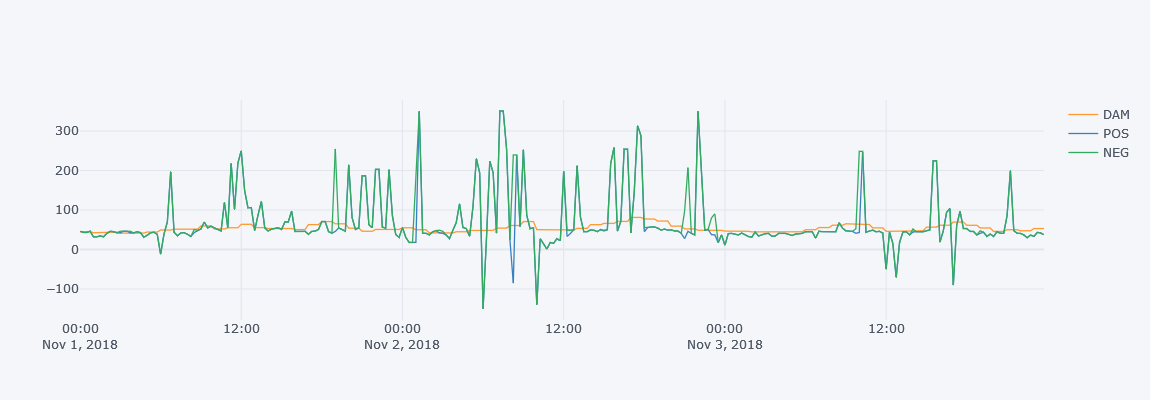

In [110]:
df[['DAM', 'POS', 'NEG']].iplot(dimensions=(1100, 400))

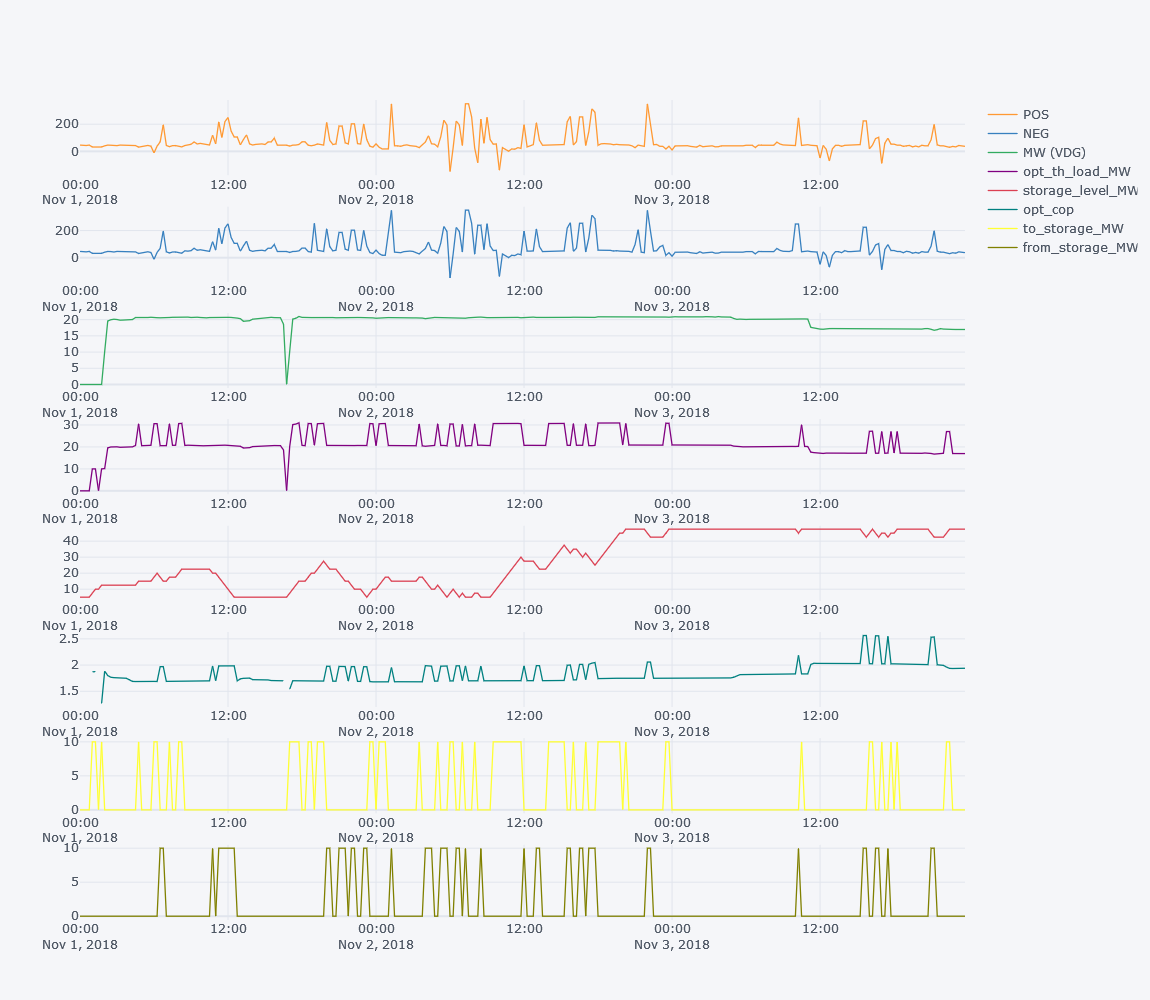

In [111]:
df[['POS', 'NEG', 'MW (VDG)', 'opt_th_load_MW', 'storage_level_MWh', 'opt_cop', 'to_storage_MW', 'from_storage_MW']].iplot(subplots=True, shape=(8, 1), dimensions=(1200, 1000))

In [113]:
df.head()

Tsource (VDG)  Tsink (VDG)  MW (VDG)  \
2018-11-01 00:00:00+01:00      64.964783   142.003109       0.0   
2018-11-01 00:15:00+01:00      54.578777   138.960493       0.0   
2018-11-01 00:30:00+01:00      65.166672   139.885329       0.0   
2018-11-01 00:45:00+01:00      65.358078   139.731901       0.0   
2018-11-01 01:00:00+01:00      64.947536   139.577871       0.0   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)    DAM    POS  \
2018-11-01 00:00:00+01:00      19.897433   147.731814       0.0  44.90  46.39   
2018-11-01 00:15:00+01:00      17.950905   148.138964       0.0  44.90  43.08   
2018-11-01 00:30:00+01:00      33.500757   147.585426       0.0  44.90  43.13   
2018-11-01 00:45:00+01:00      42.203876   147.547612       0.0  44.90  46.29   
2018-11-01 01:00:00+01:00      18.702675   148.260335       0.0  42.46  32.03   

                             NEG    ForeNeg  ...  bl_e_load_MW  bl_th_load_MW  \
2018-11-01 00:00:00+01:00  46.39  53.603333  ...          -0.0            0.0   
2018-11-01 00:15:00+01:00  43.08  68.962000  ...          -0.0            0.0   
2018-11-01 00:30:00+01:00  43.13  55.415333  ...          -0.0            0.0   
2018-11-01 00:45:00+01:00  46.29  57.633333  ...          -0.0            0.0   
2018-11-01 01:00:00+01:00  32.03  37.354000  ...          -0.0            0.0   

                           bl_cop  opt_e_load_MW  opt_th_load_MW  \
2018-11-01 00:00:00+01:00     NaN       -0.00000             0.0   
2018-11-01 00:15:00+01:00     NaN       -0.00000             0.0   
2018-11-01 00:30:00+01:00     NaN       -0.00000             0.0   
2018-11-01 00:45:00+01:00     NaN       -0.00000             0.0   
2018-11-01 01:00:00+01:00     NaN       -5.34686            10.0   

                           storage_level_MWh  opt_Tsource   opt_cop  \
2018-11-01 00:00:00+01:00                5.0    64.964783       NaN   
2018-11-01 00:15:00+01:00                5.0    54.578777       NaN   
2018-11-01 00:30:00+01:00                5.0    65.166672       NaN   
2018-11-01 00:45:00+01:00                5.0    65.358078       NaN   
2018-11-01 01:00:00+01:00                7.5    64.947536  1.870257   

                           to_storage_MW  from_storage_MW  
2018-11-01 00:00:00+01:00            0.0              0.0  
2018-11-01 00:15:00+01:00            0.0              0.0  
2018-11-01 00:30:00+01:00            0.0              0.0  
2018-11-01 00:45:00+01:00            0.0              0.0  
2018-11-01 01:00:00+01:00           10.0              0.0  

[5 rows x 21 columns]

In [ ]:
def calc_costs(df, nomination_col, realisation_col):
    dayahead_costs = df[nomination_col] * df['DAM'] 

    imbalance = df[realisation_col] - df['nomination_col']
    imbalance_costs = pd.Series(index=df.index, 0)
    is_pos = imbalance > 0
    imbalance_costs[is_pos] = imbalance[is_pos] * df['POS'] 

    is_neg = imbalance < 0
    imbalance_costs[is_neg] = -imbalance[is_neg] * df['NEG'] 

    df[f'total cost_{cons}'] = df['day-ahead costs'] + df[f'imbalance costs_{cons}']
    

In [116]:
for col in df.columns:
    if col.endswith('MW'):
        df[col + 'h'] = df[col] / 4
        
df['nomination_MWh'] = df['bl_e_load_MWh']
df['imbalance_MWh'] = df['opt_e_load_MWh'] - df['nomination_MWh']

for cons in ['baseline', 'new']:


In [117]:
df.head()

Tsource (VDG)  Tsink (VDG)  MW (VDG)  \
2018-11-01 00:00:00+01:00      64.964783   142.003109       0.0   
2018-11-01 00:15:00+01:00      54.578777   138.960493       0.0   
2018-11-01 00:30:00+01:00      65.166672   139.885329       0.0   
2018-11-01 00:45:00+01:00      65.358078   139.731901       0.0   
2018-11-01 01:00:00+01:00      64.947536   139.577871       0.0   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)    DAM    POS  \
2018-11-01 00:00:00+01:00      19.897433   147.731814       0.0  44.90  46.39   
2018-11-01 00:15:00+01:00      17.950905   148.138964       0.0  44.90  43.08   
2018-11-01 00:30:00+01:00      33.500757   147.585426       0.0  44.90  43.13   
2018-11-01 00:45:00+01:00      42.203876   147.547612       0.0  44.90  46.29   
2018-11-01 01:00:00+01:00      18.702675   148.260335       0.0  42.46  32.03   

                             NEG    ForeNeg  ...  to_storage_MW  \
2018-11-01 00:00:00+01:00  46.39  53.603333  ...            0.0   
2018-11-01 00:15:00+01:00  43.08  68.962000  ...            0.0   
2018-11-01 00:30:00+01:00  43.13  55.415333  ...            0.0   
2018-11-01 00:45:00+01:00  46.29  57.633333  ...            0.0   
2018-11-01 01:00:00+01:00  32.03  37.354000  ...           10.0   

                           from_storage_MW  bl_e_load_MWh  bl_th_load_MWh  \
2018-11-01 00:00:00+01:00              0.0           -0.0             0.0   
2018-11-01 00:15:00+01:00              0.0           -0.0             0.0   
2018-11-01 00:30:00+01:00              0.0           -0.0             0.0   
2018-11-01 00:45:00+01:00              0.0           -0.0             0.0   
2018-11-01 01:00:00+01:00              0.0           -0.0             0.0   

                           opt_e_load_MWh  opt_th_load_MWh  to_storage_MWh  \
2018-11-01 00:00:00+01:00       -0.000000              0.0             0.0   
2018-11-01 00:15:00+01:00       -0.000000              0.0             0.0   
2018-11-01 00:30:00+01:00       -0.000000              0.0             0.0   
2018-11-01 00:45:00+01:00       -0.000000              0.0             0.0   
2018-11-01 01:00:00+01:00       -1.336715              2.5             2.5   

                           from_storage_MWh  nomination_MWh  imbalance_MWh  
2018-11-01 00:00:00+01:00               0.0            -0.0       0.000000  
2018-11-01 00:15:00+01:00               0.0            -0.0       0.000000  
2018-11-01 00:30:00+01:00               0.0            -0.0       0.000000  
2018-11-01 00:45:00+01:00               0.0            -0.0       0.000000  
2018-11-01 01:00:00+01:00               0.0            -0.0      -1.336715  

[5 rows x 29 columns]

In [112]:
for i in df.index:
    df.loc[i, 'process_mass'] = process_mass_flow(df.loc[i, 'MW (VDG)'], df.loc[i, 'Tsink (VDG)'],Tref, Cp)
    hp_load = df.loc[i, 'MW (VDG)']
    baseline_COP = heatpump.get_cop(hp_load, df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)
    df.loc[i,'hp_consumption_baseline'] = hp_load/ baseline_COP
        
    if df.loc[i, 'ForeNeg'] < df['DAM'].mean() - 10:
        hp_load = heatpump.max_th_power
        energy_2_storage = hp_load - df.loc[i, 'MW (VDG)']
        waterstorage.charge(energy_2_storage)
        df.loc[i, 'charged_heat'] = waterstorage.charge(energy_2_storage)
        charge_mass = hp_mass_flow (hp_load,  df.loc[i, 'Tsink (VDG)']+273, Tref+273, Cp) - process_mass_flow (df.loc[i, 'MW (VDG)'], df.loc[i, 'Tsink (VDG)']+273, Tref+273, Cp)
        df.loc[i, 'new_cl'] = waterstorage.storagelevel
        new_COP = heatpump.get_cop(hp_load, df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)
        df.loc[i,'hp_consumption_new'] =  hp_load/ new_COP
        df.loc[i, 'energy_2_storage'] = energy_2_storage
    elif price_data.loc[i,'ForePos'] > df['DAM'].mean() + 10:
        energy_from_storage = energy_to_storage(hp_capacity ,df.loc[i, 'MW (VDG)'])
        waterstorage.discharge(energy_from_storage)
        df.loc[i, 'discharged_heat'] =   waterstorage.discharge(energy_from_storage)
        df.loc[i, 'new_cl'] = waterstorage.storagelevel
        discharge_mass = discharge_mass_flow(df.loc[i, 'discharged_heat'], Cp, Tstorage, Tref)
        df.loc[i, 'discharge_mass'] = discharge_mass
        process_mass = process_mass_flow (df.loc[i, 'MW (VDG)'], df.loc[i, 'Tsink (VDG)']+273, Tref+273, Cp)
        df.loc[i, 'Tsource_new'] = Tsource_calculation(Tstorage, df.loc[i, 'discharge_mass'], df.loc[i, 'Tsource (VDG)'], process_mass)
        heat_output = heatpump.set_heat_output(df.loc[i, 'MW (VDG)'], df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource_new']+273)
        df.loc[i,'hp_consumption_new'] = heat_output[0]
        df.loc[i, 'new_COP'] = heatpump.get_cop(heat_output[1], df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource_new']+273)
    else:
        hp_load = df.loc[i, 'MW (VDG)']
        df.loc[i, 'baseline_COP'] = baseline_COP
        df.loc[i,'hp_consumption_baseline'] =  hp_load/ baseline_COP
        df.loc[i, 'new_cl'] = 0
        df.loc[i,'hp_consumption_new'] = 0

NameError: name 'process_mass_flow' is not defined

In [18]:
df[['energy_2_storage', 'charged_heat', 'new_cl']]

energy_2_storage  charged_heat  new_cl
2018-11-01 00:00:00+01:00               NaN           NaN     0.0
2018-11-01 00:15:00+01:00               NaN           NaN     0.0
2018-11-01 00:30:00+01:00               NaN           NaN     0.0
2018-11-01 00:45:00+01:00               NaN           NaN     0.0
2018-11-01 01:00:00+01:00         40.000000          40.0    35.0
...                                     ...           ...     ...
2018-11-30 23:00:00+01:00               NaN           NaN     0.0
2018-11-30 23:15:00+01:00               NaN           NaN     0.0
2018-11-30 23:30:00+01:00         19.026030           0.0    47.5
2018-11-30 23:45:00+01:00         19.090986           0.0    47.5
2018-12-01 00:00:00+01:00               NaN           NaN     0.0

[2881 rows x 3 columns]

In [19]:
df[['ForeNeg', 'ForePos','discharged_heat', 'Tsource_new']]

ForeNeg    ForePos  discharged_heat  Tsource_new
2018-11-01 00:00:00+01:00  53.603333  44.623333              NaN          NaN
2018-11-01 00:15:00+01:00  68.962000  63.177333              NaN          NaN
2018-11-01 00:30:00+01:00  55.415333  57.922667              NaN          NaN
2018-11-01 00:45:00+01:00  57.633333  54.712667              NaN          NaN
2018-11-01 01:00:00+01:00  37.354000  35.400000              NaN          NaN
...                              ...        ...              ...          ...
2018-11-30 23:00:00+01:00  65.636000  60.364667              NaN          NaN
2018-11-30 23:15:00+01:00  54.434667  51.784667              NaN          NaN
2018-11-30 23:30:00+01:00  45.918000  44.090000              NaN          NaN
2018-11-30 23:45:00+01:00  46.302667  42.924667              NaN          NaN
2018-12-01 00:00:00+01:00  84.520000  71.147333              NaN          NaN

[2881 rows x 4 columns]

In [20]:
df['process_mass']

2018-11-01 00:00:00+01:00     0.000000
2018-11-01 00:15:00+01:00     0.000000
2018-11-01 00:30:00+01:00     0.000000
2018-11-01 00:45:00+01:00     0.000000
2018-11-01 01:00:00+01:00     0.000000
                               ...    
2018-11-30 23:00:00+01:00    33.308103
2018-11-30 23:15:00+01:00    33.377263
2018-11-30 23:30:00+01:00    33.677641
2018-11-30 23:45:00+01:00    33.674698
2018-12-01 00:00:00+01:00    33.829902
Freq: 15T, Name: process_mass, Length: 2881, dtype: float64

In [21]:
df

Tsource (VDG)  Tsink (VDG)   MW (VDG)  \
2018-11-01 00:00:00+01:00      64.964783   142.003109   0.000000   
2018-11-01 00:15:00+01:00      54.578777   138.960493   0.000000   
2018-11-01 00:30:00+01:00      65.166672   139.885329   0.000000   
2018-11-01 00:45:00+01:00      65.358078   139.731901   0.000000   
2018-11-01 01:00:00+01:00      64.947536   139.577871   0.000000   
...                                  ...          ...        ...   
2018-11-30 23:00:00+01:00      64.003609   147.889253  20.639565   
2018-11-30 23:15:00+01:00      64.127029   147.350176  20.607030   
2018-11-30 23:30:00+01:00      64.055218   148.636326  20.973970   
2018-11-30 23:45:00+01:00      63.968323   148.188946  20.909014   
2018-12-01 00:00:00+01:00      63.910389   147.856193  20.958215   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)    DAM    POS  \
2018-11-01 00:00:00+01:00      19.897433   147.731814  0.000000  44.90  46.39   
2018-11-01 00:15:00+01:00      17.950905   148.138964  0.000000  44.90  43.08   
2018-11-01 00:30:00+01:00      33.500757   147.585426  0.000000  44.90  43.13   
2018-11-01 00:45:00+01:00      42.203876   147.547612  0.000000  44.90  46.29   
2018-11-01 01:00:00+01:00      18.702675   148.260335  0.000000  42.46  32.03   
...                                  ...          ...       ...    ...    ...   
2018-11-30 23:00:00+01:00      62.243670   148.108788  6.877683  51.52  62.06   
2018-11-30 23:15:00+01:00      62.764050   152.806793  6.813993  51.52  48.13   
2018-11-30 23:30:00+01:00      62.833364   155.014082  6.925293  51.52  43.94   
2018-11-30 23:45:00+01:00      62.982220   156.614943  6.882548  51.52  35.94   
2018-12-01 00:00:00+01:00      63.192127   156.992105  6.891422  50.00  82.85   

                             NEG    ForeNeg  ...  hp_consumption_baseline  \
2018-11-01 00:00:00+01:00  46.39  53.603333  ...                 0.000000   
2018-11-01 00:15:00+01:00  43.08  68.962000  ...                 0.000000   
2018-11-01 00:30:00+01:00  43.13  55.415333  ...                 0.000000   
2018-11-01 00:45:00+01:00  46.29  57.633333  ...                 0.000000   
2018-11-01 01:00:00+01:00  32.03  37.354000  ...                 0.000000   
...                          ...        ...  ...                      ...   
2018-11-30 23:00:00+01:00  62.06  65.636000  ...                 4.113584   
2018-11-30 23:15:00+01:00  48.13  54.434667  ...                 4.079889   
2018-11-30 23:30:00+01:00  43.94  45.918000  ...                 4.207421   
2018-11-30 23:45:00+01:00  35.94  46.302667  ...                 4.180951   
2018-12-01 00:00:00+01:00  82.85  84.520000  ...                 4.180416   

                           baseline_COP  new_cl  hp_consumption_new  \
2018-11-01 00:00:00+01:00      5.386969     0.0            0.000000   
2018-11-01 00:15:00+01:00      4.882106     0.0            0.000000   
2018-11-01 00:30:00+01:00      5.525867     0.0            0.000000   
2018-11-01 00:45:00+01:00      5.549424     0.0            0.000000   
2018-11-01 01:00:00+01:00           NaN    35.0            7.235515   
...                                 ...     ...                 ...   
2018-11-30 23:00:00+01:00      5.017417     0.0            0.000000   
2018-11-30 23:15:00+01:00      5.050881     0.0            0.000000   
2018-11-30 23:30:00+01:00           NaN    47.5            8.024082   
2018-11-30 23:45:00+01:00           NaN    47.5            7.998370   
2018-12-01 00:00:00+01:00      5.013427     0.0            0.000000   

                           charged_heat  energy_2_storage  discharged_heat  \
2018-11-01 00:00:00+01:00           NaN               NaN              NaN   
2018-11-01 00:15:00+01:00           NaN               NaN              NaN   
2018-11-01 00:30:00+01:00           NaN               NaN              NaN   
2018-11-01 00:45:00+01:00           NaN               NaN              NaN   
2018-11-01 01:00:00+01:00          40.0         40.000000            

In [22]:
df.loc['2018-11-01 18:00:00+01:00', 'new_cl']

42.351294253690725

In [23]:
time_factor = 1/4

for col in price_data.columns:
    df[col] = price_data[col]
for cons in ['baseline', 'new']:
    df['nomination_MWh'] = df['MW (VDG)'] * time_factor
    df[f'imbalance_MWh_{cons}'] = df['nomination_MWh'] - (df[f'hp_consumption_{cons}']*time_factor)
    df['day-ahead costs'] = df['nomination_MWh'] * df['DAM'] 

    is_pos = df[f'imbalance_MWh_{cons}'] > 0
    df.loc[is_pos, f'imbalance costs_{cons}'] = df.loc[is_pos, f'imbalance_MWh_{cons}'] * df['POS'] 

    is_neg = df[f'imbalance_MWh_{cons}'] < 0
    df.loc[is_neg, f'imbalance costs_{cons}'] = -df.loc[is_neg, f'imbalance_MWh_{cons}'] * df['NEG'] 

    df[f'total cost_{cons}'] = df['day-ahead costs'] + df[f'imbalance costs_{cons}']

In [24]:
df['new_COP']

2018-11-01 00:00:00+01:00   NaN
2018-11-01 00:15:00+01:00   NaN
2018-11-01 00:30:00+01:00   NaN
2018-11-01 00:45:00+01:00   NaN
2018-11-01 01:00:00+01:00   NaN
                             ..
2018-11-30 23:00:00+01:00   NaN
2018-11-30 23:15:00+01:00   NaN
2018-11-30 23:30:00+01:00   NaN
2018-11-30 23:45:00+01:00   NaN
2018-12-01 00:00:00+01:00   NaN
Freq: 15T, Name: new_COP, Length: 2881, dtype: float64

In [25]:
df['DAM'].mean()

62.27883373828532

In [26]:
df['NEG'].mean()

69.33902464422076

In [27]:
df['ForePos']

2018-11-01 00:00:00+01:00    44.623333
2018-11-01 00:15:00+01:00    63.177333
2018-11-01 00:30:00+01:00    57.922667
2018-11-01 00:45:00+01:00    54.712667
2018-11-01 01:00:00+01:00    35.400000
                               ...    
2018-11-30 23:00:00+01:00    60.364667
2018-11-30 23:15:00+01:00    51.784667
2018-11-30 23:30:00+01:00    44.090000
2018-11-30 23:45:00+01:00    42.924667
2018-12-01 00:00:00+01:00    71.147333
Freq: 15T, Name: ForePos, Length: 2881, dtype: float64

#### VISUALIZATION

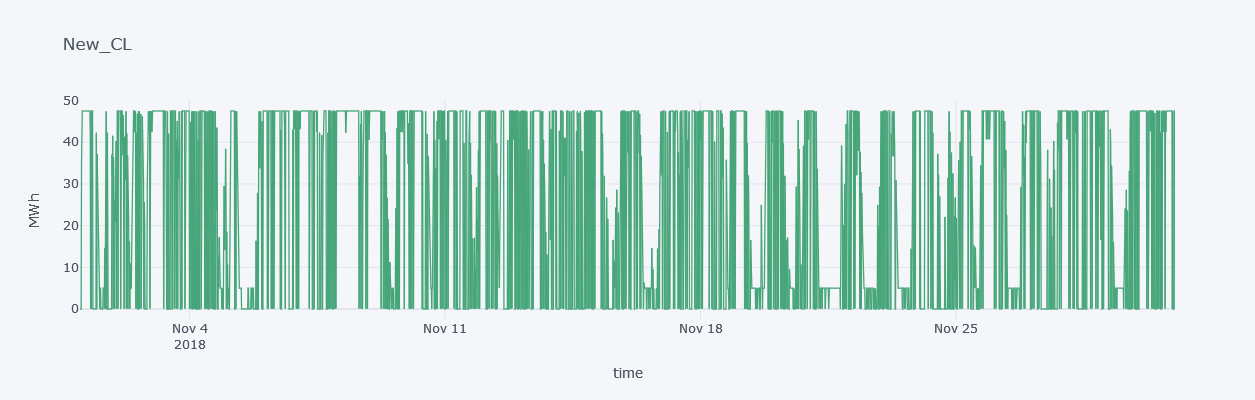

In [28]:
fig_storage_level_over_time = df['new_cl'].iplot(
    title='New_CL',
    xTitle='time',
    yTitle='MWh', 
    colors=recoygreen,
    asFigure=True,
    dimensions=(1000, 400)
)
fig_storage_level_over_time

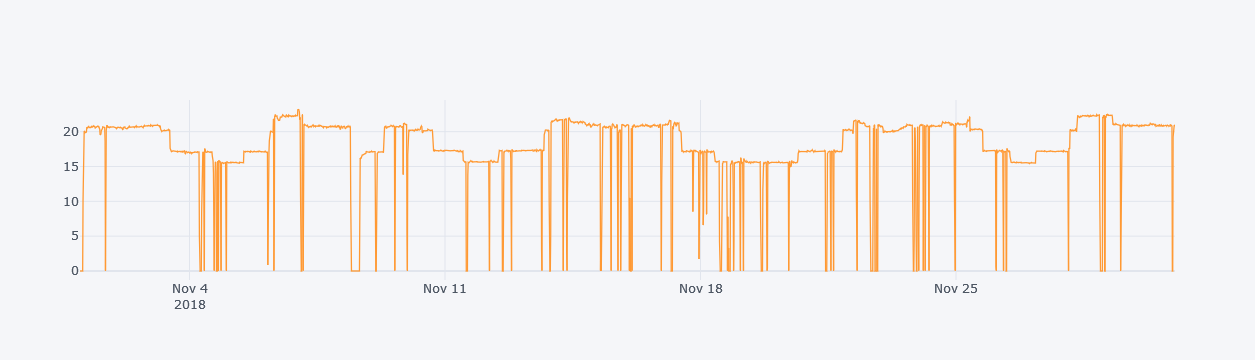

In [29]:
df['MW (VDG)'].iplot()

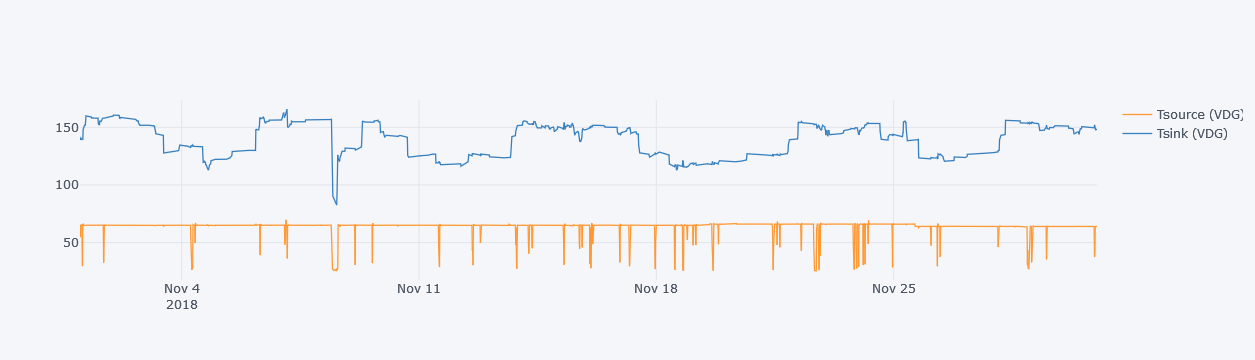

In [30]:
df[['Tsource (VDG)', 'Tsink (VDG)']].iplot()

In [31]:
df['Tsource (VDG)'].mean()

63.66131929339985

In [32]:
# Imbalance_price = df[['NEG', 'DAM'].iplot(
#     subplots=True, 
#     title='Market price',
#     subplot_titles=['Imbalance price(€/MWh)', 'Electricity price(€/MWh)'],
#     legend=False,
#     dimensions=(800, 600),
#     colors=[recoydarkblue, recoygreen],
#     asFigure=True
# )
# Imbalance_price

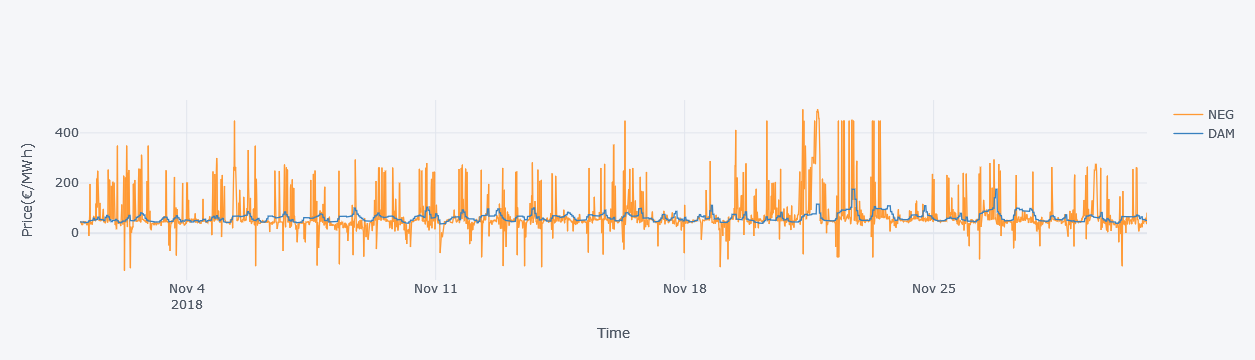

In [33]:
df[['NEG', 'DAM']].iplot(kind = 'line', xTitle='Time', yTitle='Price(€/MWh)')

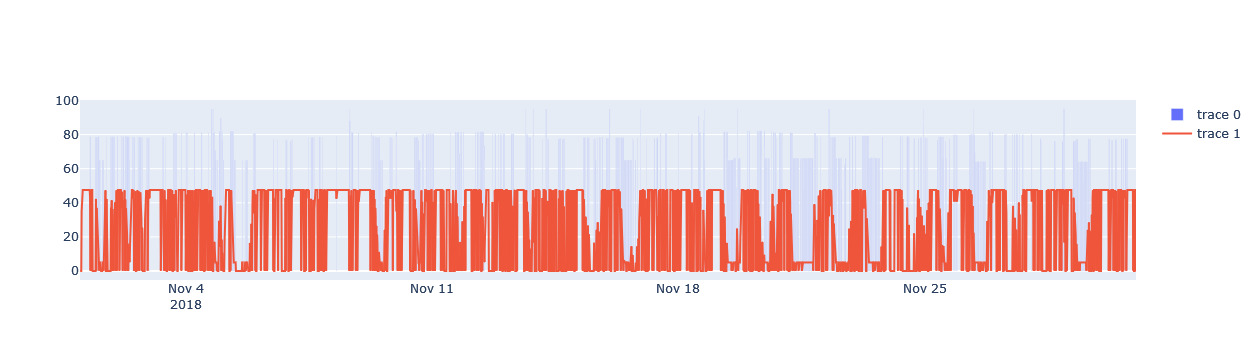

In [34]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    x=df.index,
    y=df['Tsource_new'],

    # xperiodalignment="middle",
    # xhoverformat="Q%q",
    # hovertemplate="%{y}%{_xother}"
))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['new_cl'],
    # xperiodalignment="middle",
    # hovertemplate="%{y}%{_xother}"
))

fig.update_layout(hovermode="x unified")
fig.show()

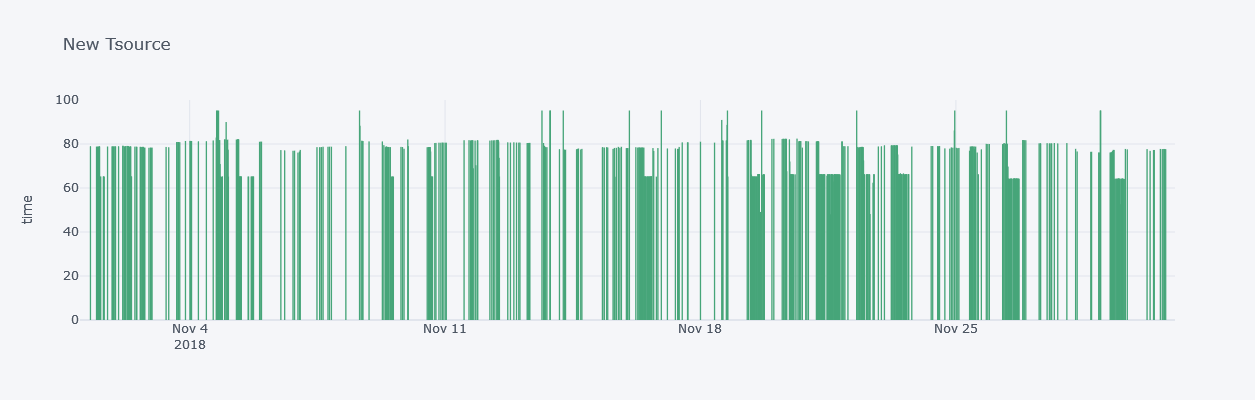

In [35]:
Tsource_new = df['Tsource_new']
Tsource_new= Tsource_new.iplot(
    kind='bar',
    title='New Tsource',
    colors=recoygreen,
    dimensions=(600, 400),
    yTitle='time'
)
Tsource_new

In [36]:
df['total cost_baseline']

2018-11-01 00:00:00+01:00           NaN
2018-11-01 00:15:00+01:00           NaN
2018-11-01 00:30:00+01:00           NaN
2018-11-01 00:45:00+01:00           NaN
2018-11-01 01:00:00+01:00           NaN
                                ...    
2018-11-30 23:00:00+01:00    522.238190
2018-11-30 23:15:00+01:00    464.281378
2018-11-30 23:30:00+01:00    454.325279
2018-11-30 23:45:00+01:00    419.609743
2018-12-01 00:00:00+01:00    609.487824
Freq: 15T, Name: total cost_baseline, Length: 2881, dtype: float64

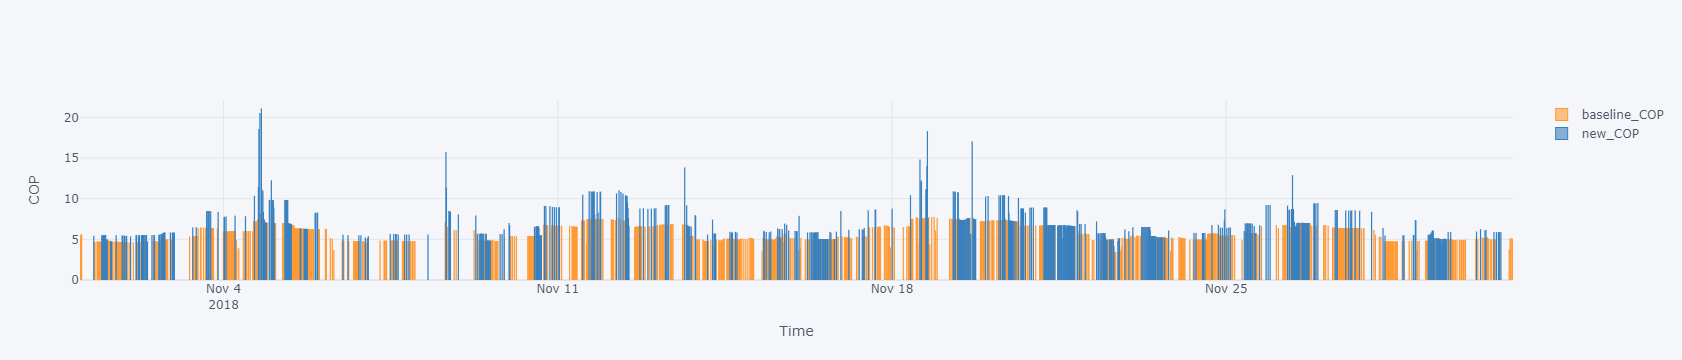

In [37]:
df[['baseline_COP', 'new_COP']].iplot(kind = 'bar', xTitle='Time', yTitle='COP')

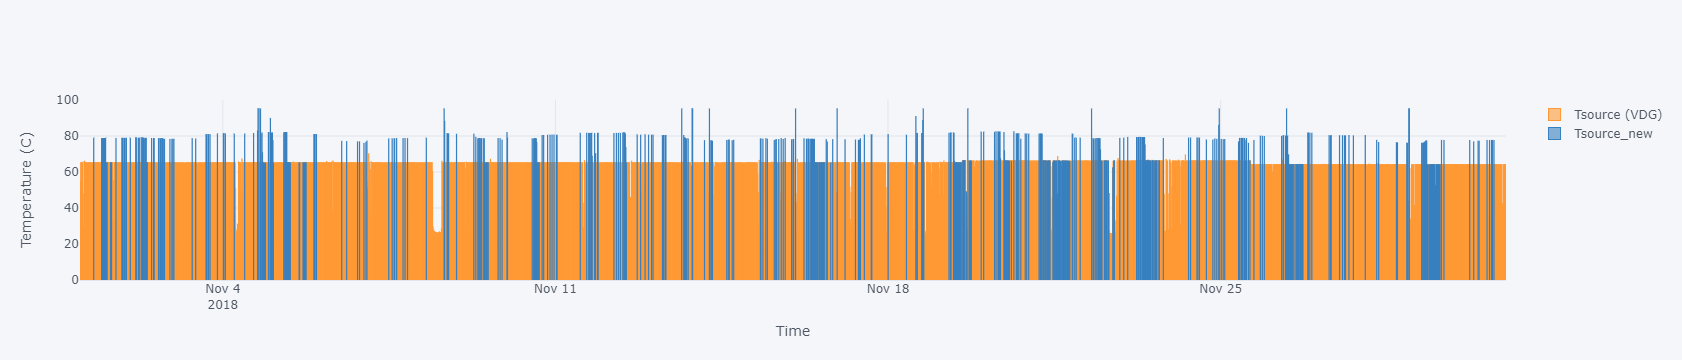

In [38]:
df[['Tsource (VDG)', 'Tsource_new']].iplot(kind = 'bar', xTitle='Time', yTitle='Temperature (C)')

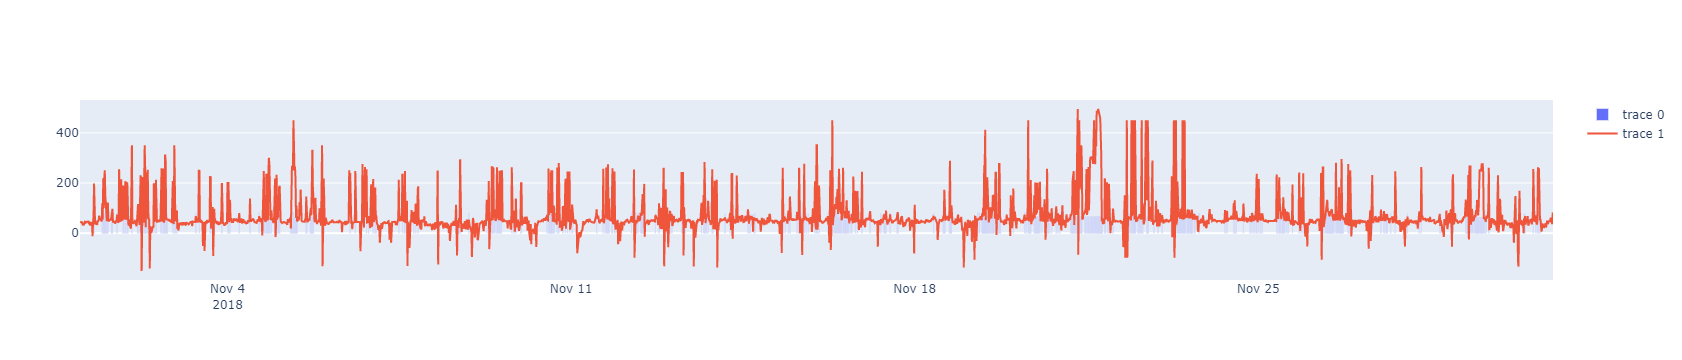

In [39]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    x=df.index,
    y=df['Tsource_new'],

    # xperiodalignment="middle",
    # xhoverformat="Q%q",
    # hovertemplate="%{y}%{_xother}"
))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['NEG'],
    # xperiodalignment="middle",
    # hovertemplate="%{y}%{_xother}"
))

fig.update_layout(hovermode="x unified")
fig.show()

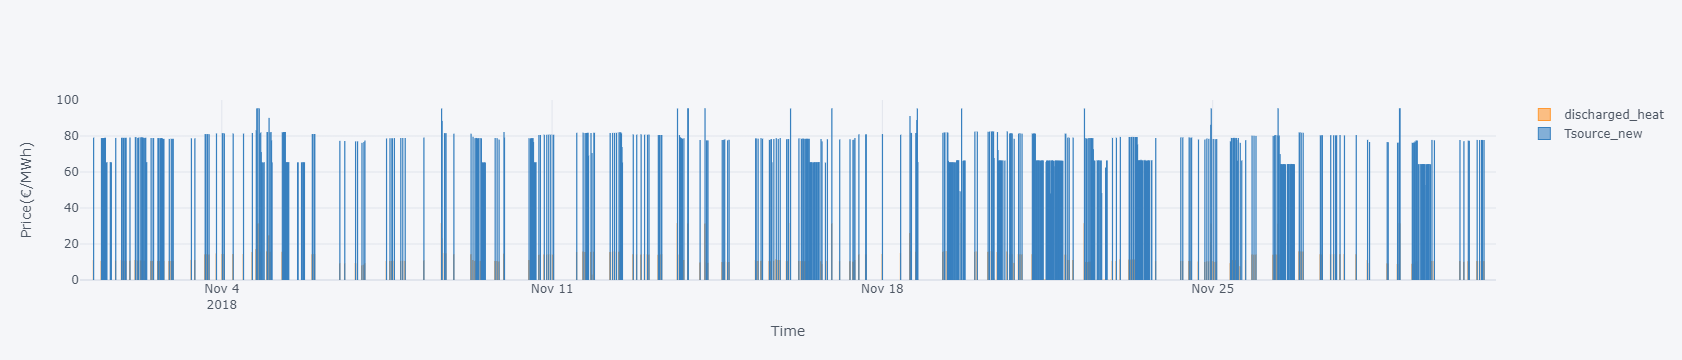

In [40]:
df[['discharged_heat', 'Tsource_new']].iplot(kind = 'bar', xTitle='Time', yTitle='Price(€/MWh)')

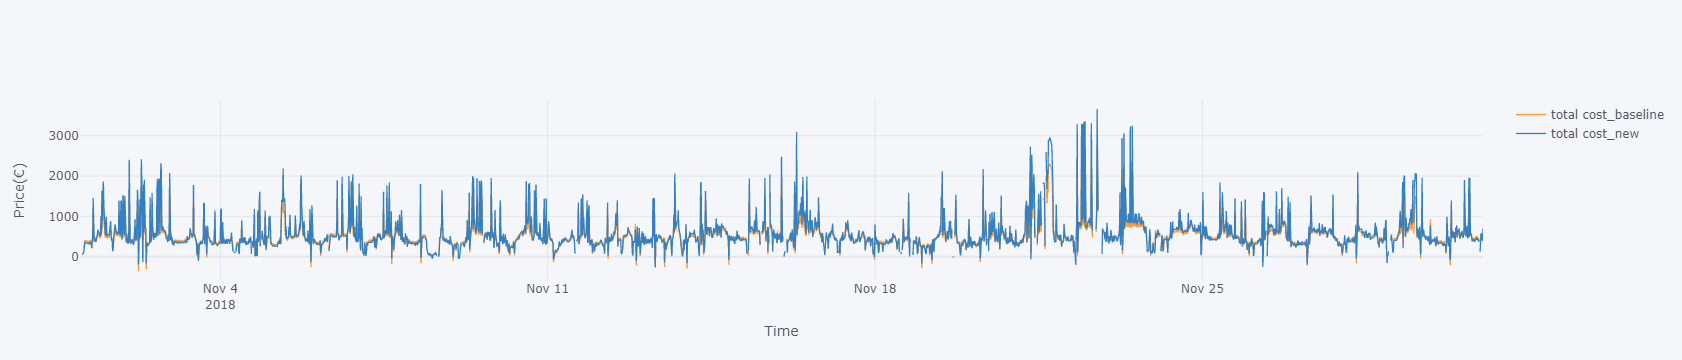

In [41]:
df[['total cost_baseline', 'total cost_new']].iplot(kind = 'line', xTitle='Time', yTitle='Price(€)')

In [42]:
print(df['total cost_new'].sum())
print(df['total cost_baseline'].sum())

1611566.3265981267
1463381.24579542
